# Multitask QEP Regression

## Introduction

Multitask regression, introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

Given inputs $x$ and $x'$, and tasks $i$ and $j$, the covariance between two datapoints and two tasks is given by

$$  k([x, i], [x', j]) = k_\text{inputs}(x, x') * k_\text{tasks}(i, j)
$$

where $k_\text{inputs}$ is a standard kernel (e.g. RBF) that operates on the inputs.
$k_\text{task}$ is a lookup table containing inter-task covariance.

In [1]:
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library 'libomp' not found.
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have two functions - a sine function (y1) and a cosine function (y2).

For MTGPs, our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

## Define a multitask model

The model should be somewhat similar to the `ExactQEP` model in the [simple regression example](../01_Exact_QEPs/Simple_QEP_Regression.ipynb).
The differences:

1. We're going to wrap ConstantMean with a `MultitaskMean`. This makes sure we have a mean function for each task.
2. Rather than just using a RBFKernel, we're using that in conjunction with a `MultitaskKernel`. This gives us the covariance function described in the introduction.
3. We're using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood`. This allows us to deal with the predictions/outputs in a nice way. For example, when we call MultitaskMultivariateNormal.mean, we get a `n x num_tasks` matrix back.

You may also notice that we don't use a ScaleKernel, since the MultitaskKernel will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [3]:
POWER = 1.0
class MultitaskQEPModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskQEPModel, self).__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.MultitaskMean(
            qpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = qpytorch.kernels.MultitaskKernel(
            qpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultitaskMultivariateQExponential(mean_x, covar_x, power=self.power)

    
likelihood = qpytorch.likelihoods.MultitaskQExponentialLikelihood(num_tasks=2, power=torch.tensor(POWER))
model = MultitaskQEPModel(train_x, train_y, likelihood)

### Train the model hyperparameters

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 2.046
Iter 2/50 - Loss: 1.999
Iter 3/50 - Loss: 1.948
Iter 4/50 - Loss: 1.893
Iter 5/50 - Loss: 1.833
Iter 6/50 - Loss: 1.769
Iter 7/50 - Loss: 1.704
Iter 8/50 - Loss: 1.641
Iter 9/50 - Loss: 1.585
Iter 10/50 - Loss: 1.538
Iter 11/50 - Loss: 1.502
Iter 12/50 - Loss: 1.473
Iter 13/50 - Loss: 1.450
Iter 14/50 - Loss: 1.430
Iter 15/50 - Loss: 1.411
Iter 16/50 - Loss: 1.393
Iter 17/50 - Loss: 1.375
Iter 18/50 - Loss: 1.358
Iter 19/50 - Loss: 1.340
Iter 20/50 - Loss: 1.322
Iter 21/50 - Loss: 1.304
Iter 22/50 - Loss: 1.286
Iter 23/50 - Loss: 1.267
Iter 24/50 - Loss: 1.247
Iter 25/50 - Loss: 1.227
Iter 26/50 - Loss: 1.207
Iter 27/50 - Loss: 1.186
Iter 28/50 - Loss: 1.165
Iter 29/50 - Loss: 1.143
Iter 30/50 - Loss: 1.121
Iter 31/50 - Loss: 1.098
Iter 32/50 - Loss: 1.075
Iter 33/50 - Loss: 1.052
Iter 34/50 - Loss: 1.029
Iter 35/50 - Loss: 1.006
Iter 36/50 - Loss: 0.983
Iter 37/50 - Loss: 0.960
Iter 38/50 - Loss: 0.937
Iter 39/50 - Loss: 0.913
Iter 40/50 - Loss: 0.890
Iter 41/5

### Make predictions with the model

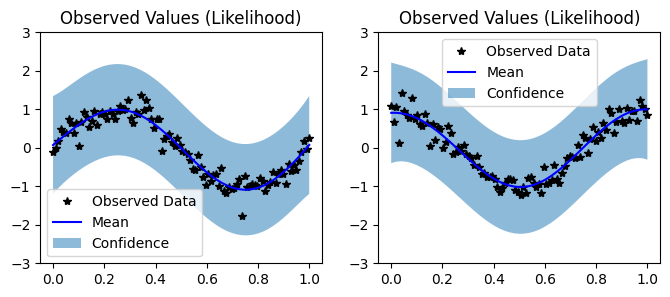

In [7]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), qpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region(.1)
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None